In [34]:
import ast
import math
import os

FILE_ORIGINAL = "huopm_results/Retail/HUOPM_Original/Retail_HUOPM_Original_a0.001_b0.2.txt"
FILE_IMPROVED = "huopm_improved_results/Retail/HUOPM_Improved/Retail_HUOPM_Improved_a0.001_b0.2.txt"
TOLERANCE = 1e-9 

def load_patterns_robust(filepath):
    """
    Reads the file, handles 'One Big Line' formatting issues, 
    and returns a dictionary of patterns.
    """
    patterns = {}
    
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    with open(filepath, 'r', encoding='utf-8') as f:
        raw_content = f.read()

    # --- FIX 1: Handle Literal Newlines ---
    # If the file was saved with literal "\n" characters, replace them with real newlines
    if "\\n" in raw_content:
        # print(f"   Detected literal '\\n' in {os.path.basename(filepath)}. Fixing format...")
        content = raw_content.replace("\\n", "\n")
    else:
        content = raw_content

    # --- FIX 2: Split and Parse ---
    lines = content.split('\n')
    
    for line in lines:
        line = line.strip()
        # Skip empty lines, comments, or separators
        if not line or line.startswith('#') or line.startswith('-'):
            continue
        
        try:
            # Parse line: (('item',), support, uo)
            entry = ast.literal_eval(line)
            
            # Ensure it looks like our data structure
            if isinstance(entry, tuple) and len(entry) == 3:
                itemset = tuple(entry[0])
                support = int(entry[1])
                uo = float(entry[2])
                patterns[itemset] = {'sup': support, 'uo': uo}
        except (ValueError, SyntaxError):
            # Ignore lines that aren't valid tuples
            continue
            
    return patterns

def compare_files():
    print(f"Loading Files")
    data_orig = load_patterns_robust(FILE_ORIGINAL)
    data_imp = load_patterns_robust(FILE_IMPROVED)
    
    if data_orig is None or data_imp is None:
        return

    count_orig = len(data_orig)
    count_imp = len(data_imp)
    
    print(f"\nOriginal Patterns Found: {count_orig}")
    print(f"Improved Patterns Found: {count_imp}")
    
    # 1. Check Count Equality
    if count_orig != count_imp:
        print(f"\nFAILURE: Pattern counts do not match!")
        print(f"   Difference: {abs(count_orig - count_imp)}")
    else:
        print(f"\nCounts match exactly.")

    # 2. Compare Content
    print("\n--- Comparing Values ---")
    mismatches = []
    
    # Check if Original patterns exist in Improved with same values
    for itemset, vals_orig in data_orig.items():
        if itemset not in data_imp:
            mismatches.append(f"Missing in Improved: {itemset}")
        else:
            vals_imp = data_imp[itemset]
            sup_match = vals_orig['sup'] == vals_imp['sup']
            uo_match = math.isclose(vals_orig['uo'], vals_imp['uo'], rel_tol=TOLERANCE)
            
            if not sup_match or not uo_match:
                mismatches.append(f"Value Mismatch for {itemset}:\n      Orig: {vals_orig}\n      Imp:  {vals_imp}")

    # Check if Improved has extras
    for itemset in data_imp:
        if itemset not in data_orig:
            mismatches.append(f"Extra in Improved (Missing in Orig): {itemset}")

    if not mismatches:
        print("SUCCESS: All patterns and values match perfectly!")
    else:
        print(f"Found {len(mismatches)} discrepancies.")
        print("First 5 mismatches:")
        for m in mismatches[:5]:
            print(" - " + m)

if __name__ == "__main__":
    compare_files()

Loading Files

Original Patterns Found: 751
Improved Patterns Found: 751

Counts match exactly.

--- Comparing Values ---
SUCCESS: All patterns and values match perfectly!


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

PATH_ORIGINAL_ROOT = "huopm_results"
PATH_IMPROVED_ROOT = "huopm_improved_results"
OUTPUT_DIR = "huopm_comparison_plots"

os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

def generate_comparison_plot(dataset_name):
    """
    Loads Original vs. Improved summary CSVs for a specific dataset
    and displays a side-by-side Runtime & Memory plot directly.
    """
    print(f" Processing Dataset: {dataset_name}...")
    
    # 1. Construct File Paths
    file_orig = os.path.join(
        PATH_ORIGINAL_ROOT, 
        dataset_name, 
        "HUOPM_Original", 
        f"{dataset_name}_HUOPM_Original_summary.csv"
    )
    
    file_imp = os.path.join(
        PATH_IMPROVED_ROOT, 
        dataset_name, 
        "HUOPM_Improved", 
        f"{dataset_name}_HUOPM_Improved_summary.csv"
    )
    
    # 2. Load Data
    dfs = []
    
    # Load Original
    if os.path.exists(file_orig):
        df_o = pd.read_csv(file_orig)
        df_o['Version'] = 'Original'
        dfs.append(df_o)
    else:
        print(f"    Original file missing: {file_orig}")

    # Load Improved
    if os.path.exists(file_imp):
        df_i = pd.read_csv(file_imp)
        df_i['Version'] = 'Improved'
        dfs.append(df_i)
    else:
        print(f"    Improved file missing: {file_imp}")
    
    if not dfs:
        print(f"    No data available for {dataset_name}. Skipping plot.")
        return

    # Combine DataFrames
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined.sort_values(by=['alpha', 'beta'], ascending=[False, True], inplace=True)

    # 3. Generate Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'HUOPM Comparison: {dataset_name}', fontsize=16, weight='bold')
    
    # Colors: Red for Original, Green for Improved
    palette = {'Original': '#D32F2F', 'Improved': '#388E3C'}
    
    # Plot A: Runtime
    sns.lineplot(
        ax=axes[0], data=df_combined, x='alpha', y='runtime_sec', 
        hue='Version', style='beta', palette=palette,
        markers=True, dashes=False, linewidth=2.5, markersize=8
    )
    axes[0].set_title('Runtime Comparison (Lower is Better)')
    axes[0].set_ylabel('Time (Seconds)')
    axes[0].set_xlabel('Minimum Support (Alpha)')
    axes[0].invert_xaxis() 
    
    # Plot B: Memory
    sns.lineplot(
        ax=axes[1], data=df_combined, x='alpha', y='peak_memory_mb', 
        hue='Version', style='beta', palette=palette,
        markers=True, dashes=False, linewidth=2.5, markersize=8
    )
    axes[1].set_title('Memory Usage Comparison (Lower is Better)')
    axes[1].set_ylabel('Peak Memory (MB)')
    axes[1].set_xlabel('Minimum Support (Alpha)')
    axes[1].invert_xaxis()

    # 4. Show and Save
    output_path = os.path.join(OUTPUT_DIR, f"{dataset_name}_Comparison.png")
    plt.savefig(output_path, dpi=300)
    
    print(f"    Data Loaded: {len(df_combined)} records")
    plt.show() # Displays plot directly in the notebook cell
    print(f"    Plot saved to: {output_path}")

 Processing Dataset: Retail...
    Data Loaded: 12 records


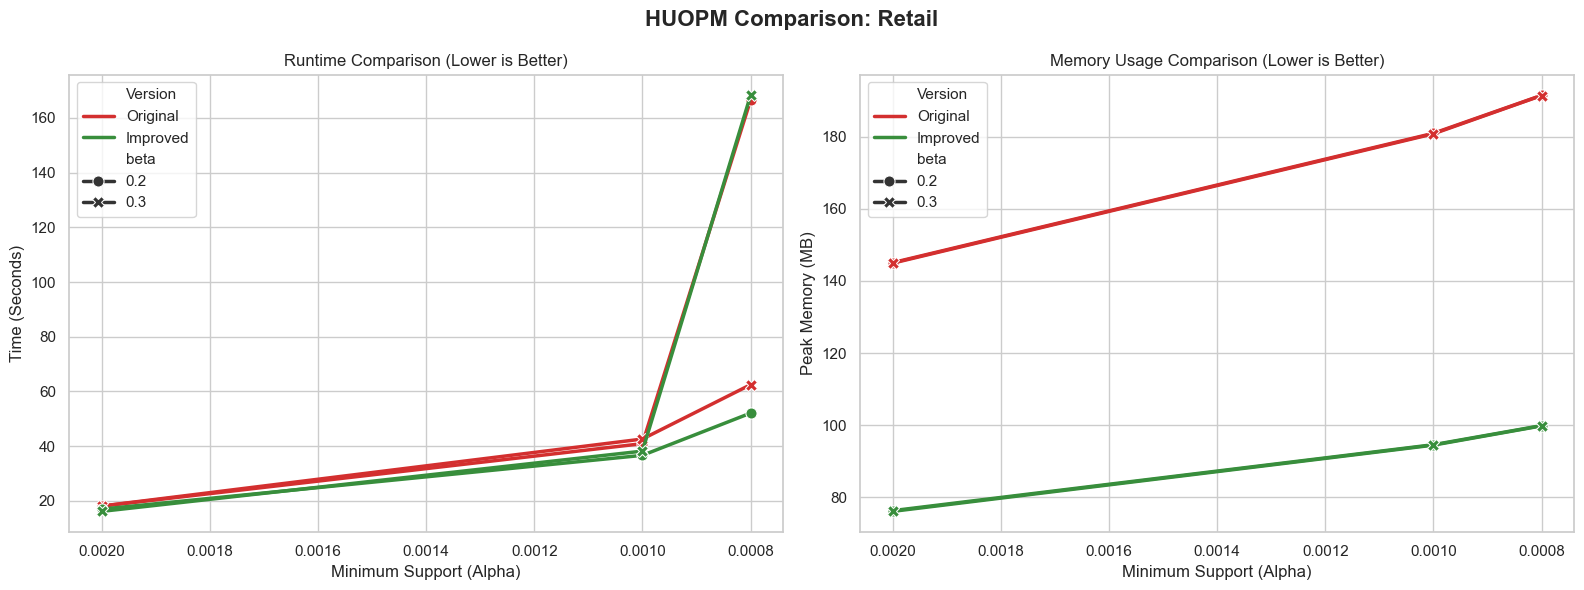

    Plot saved to: huopm_comparison_plots/Retail_Comparison.png


In [36]:
generate_comparison_plot("Retail")

 Processing Dataset: Foodmart...
    Data Loaded: 12 records


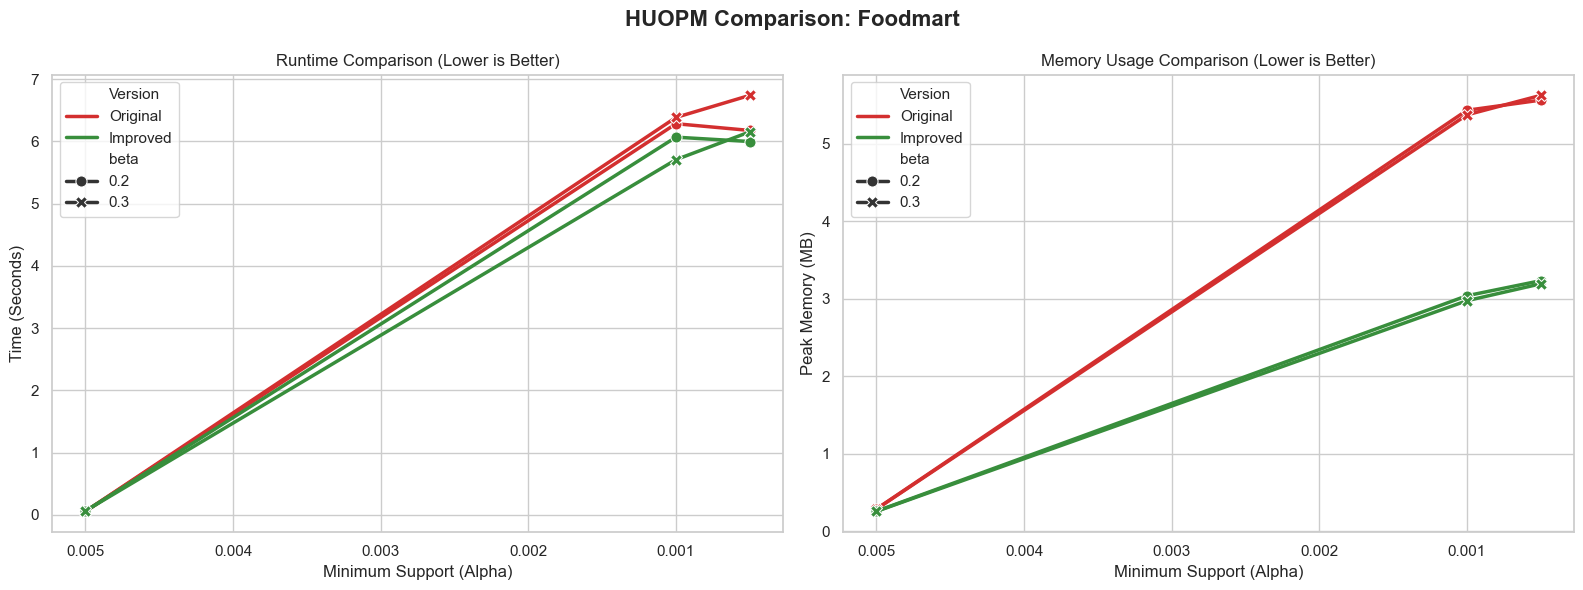

    Plot saved to: huopm_comparison_plots/Foodmart_Comparison.png


In [37]:
generate_comparison_plot("Foodmart")

 Processing Dataset: Mushroom...
    Data Loaded: 12 records


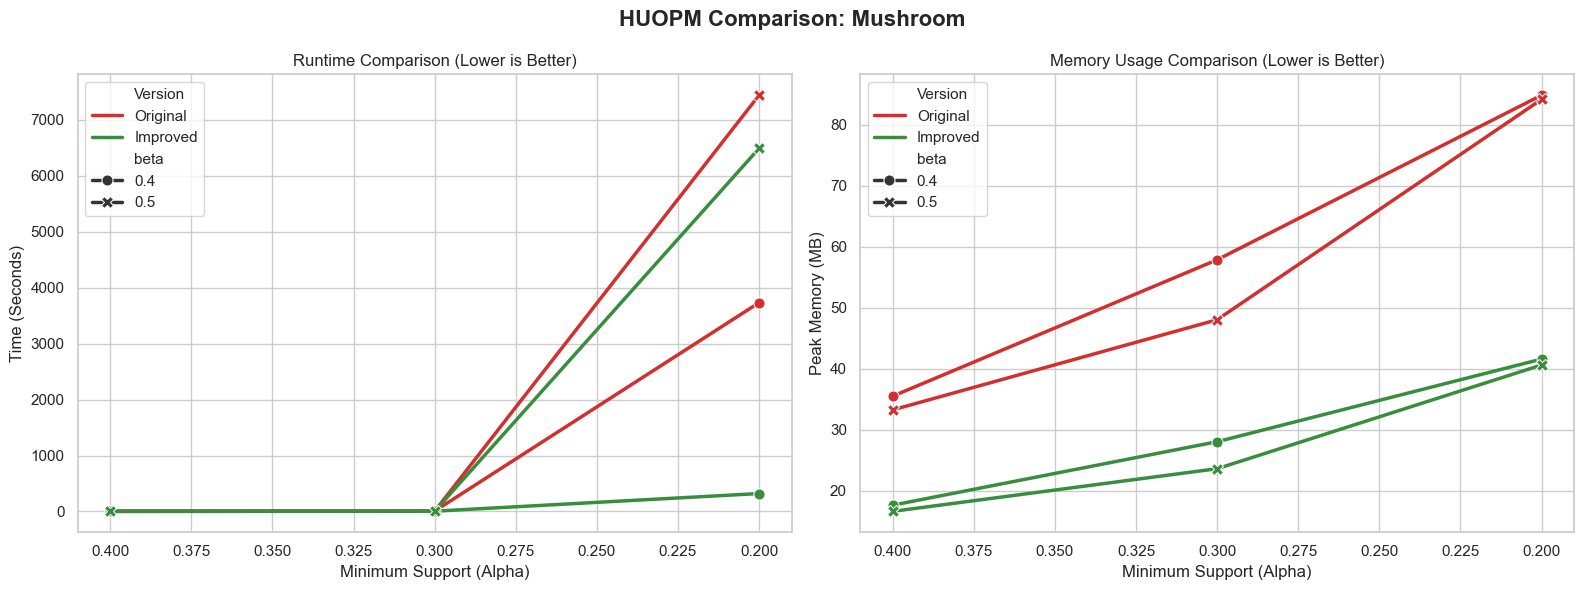

    Plot saved to: huopm_comparison_plots/Mushroom_Comparison.png


In [38]:
generate_comparison_plot("Mushroom")

 Processing Dataset: Chainstore...
    Data Loaded: 2 records


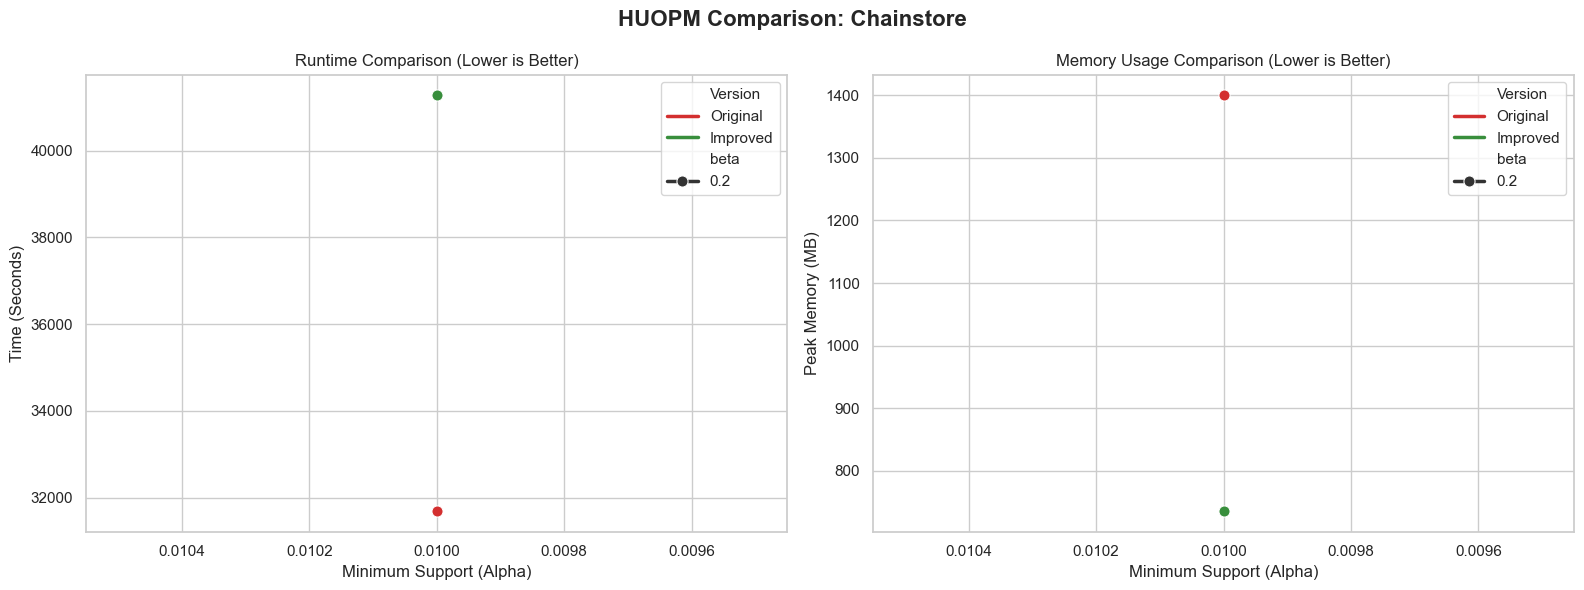

    Plot saved to: huopm_comparison_plots/Chainstore_Comparison.png


In [39]:
generate_comparison_plot("Chainstore")

In [40]:
PATH_HUOPM_ORIG = "huopm_results"
PATH_HUOPM_IMP = "huopm_improved_results"
PATH_HUOMIL = "huomil_results"
OUTPUT_DIR = "algo_comparison_plots"

os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

def load_summary_file(filepath, algo_name):
    """Helper to safely load and label data"""
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath)
            df['Algorithm'] = algo_name
            # Ensure standard column names
            df.rename(columns={
                'Runtime(s)': 'runtime_sec', 
                'Memory(MB)': 'peak_memory_mb',
                'Patterns': 'patterns_found'
            }, inplace=True, errors='ignore')
            return df
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    return None

def generate_three_way_comparison(dataset_name):
    print(f"\nProcessing Comparison: {dataset_name}...")
    
    # 1. Define File Paths
    files = {
        "HUOPM Original": os.path.join(PATH_HUOPM_ORIG, dataset_name, "HUOPM_Original", f"{dataset_name}_HUOPM_Original_summary.csv"),
        "HUOPM Improved": os.path.join(PATH_HUOPM_IMP, dataset_name, "HUOPM_Improved", f"{dataset_name}_HUOPM_Improved_summary.csv"),
        "HUOMIL": os.path.join(PATH_HUOMIL, dataset_name, f"{dataset_name}_summary.csv")
    }
    
    # 2. Load Data
    dfs = []
    for algo, path in files.items():
        df = load_summary_file(path, algo)
        if df is not None:
            dfs.append(df)
            print(f"  Loaded {algo}: {len(df)} records")
        else:
            print(f"  Missing {algo} at {path}")
    
    if not dfs:
        print("  No data found. Skipping.")
        return

    df_combined = pd.concat(dfs, ignore_index=True)
    
    # 3. Setup Plotting (3 Subplots)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f'Algorithm Benchmark: {dataset_name}', fontsize=18, weight='bold')
    
    # Define Colors: Red (Old), Green (Improved), Blue (HUOMIL)
    palette = {'HUOPM Original': '#D32F2F', 'HUOPM Improved': '#388E3C', 'HUOMIL': '#1976D2'}
    
    # --- Plot A: Runtime vs Alpha ---
    # Log scale X-axis helps when parameters differ by orders of magnitude (e.g. 0.001 vs 0.1)
    sns.lineplot(
        ax=axes[0], data=df_combined, x='alpha', y='runtime_sec', 
        hue='Algorithm', style='beta', palette=palette,
        markers=True, dashes=False, linewidth=2.5, markersize=8
    )
    axes[0].set_title('Runtime vs. Support (Alpha)', fontsize=14)
    axes[0].set_ylabel('Time (Seconds)')
    axes[0].set_xlabel('Minimum Support (Alpha)')
    axes[0].invert_xaxis()  # Harder tasks (lower alpha) on the right
    # Optional: Log Scale for X if ranges differ wildly
    # axes[0].set_xscale('log') 

    # --- Plot B: Memory vs Alpha ---
    sns.lineplot(
        ax=axes[1], data=df_combined, x='alpha', y='peak_memory_mb', 
        hue='Algorithm', style='beta', palette=palette,
        markers=True, dashes=False, linewidth=2.5, markersize=8
    )
    axes[1].set_title('Memory Usage vs. Support', fontsize=14)
    axes[1].set_ylabel('Peak Memory (MB)')
    axes[1].set_xlabel('Minimum Support (Alpha)')
    axes[1].invert_xaxis()

    # --- Plot C: Runtime vs Patterns Found (The Efficiency Frontier) ---
    # This compares apples-to-apples: "Time taken to find X patterns"
    # Great for mismatched alphas
    sns.lineplot(
        ax=axes[2], data=df_combined, x='patterns_found', y='runtime_sec', 
        hue='Algorithm', style='beta', palette=palette,
        markers=True, dashes=False, linewidth=2.5, markersize=8
    )
    axes[2].set_title('Efficiency: Runtime vs. Patterns Found', fontsize=14)
    axes[2].set_ylabel('Time (Seconds)')
    axes[2].set_xlabel('Number of Patterns Found (Log Scale)')
    axes[2].set_xscale('log') # Patterns often grow exponentially

    # 4. Save
    output_path = os.path.join(OUTPUT_DIR, f"{dataset_name}_3Way_Comparison.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  Plot saved to: {output_path}")


Processing Comparison: Retail...
  Loaded HUOPM Original: 6 records
  Loaded HUOPM Improved: 6 records
  Loaded HUOMIL: 6 records


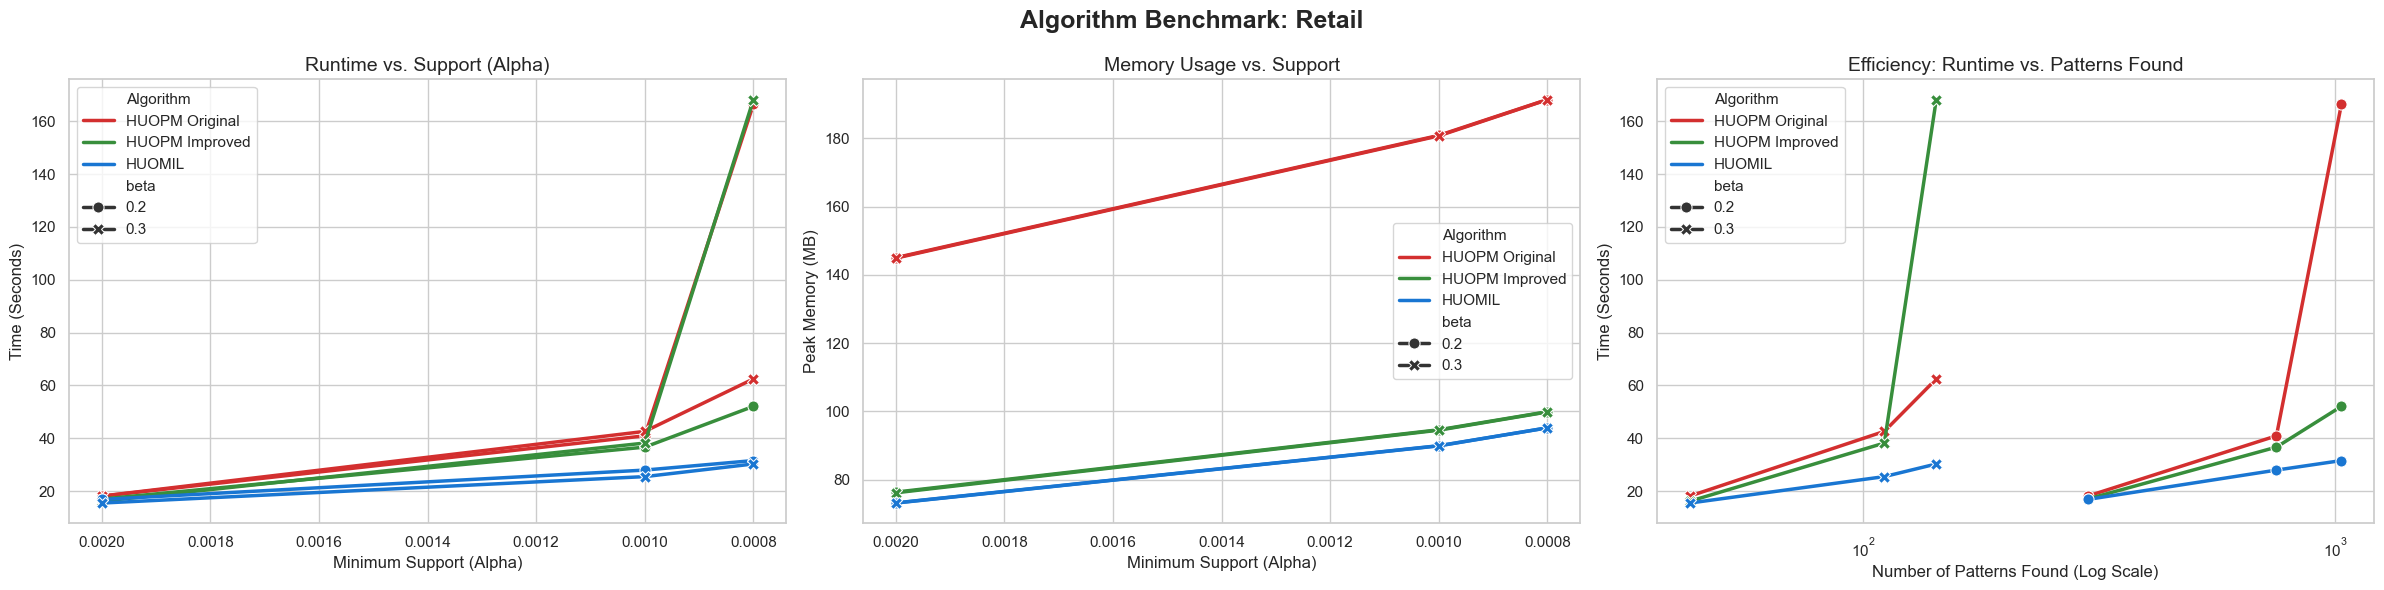

  Plot saved to: algo_comparison_plots/Retail_3Way_Comparison.png


In [41]:
generate_three_way_comparison("Retail")


Processing Comparison: Foodmart...
  Loaded HUOPM Original: 6 records
  Loaded HUOPM Improved: 6 records
  Loaded HUOMIL: 6 records


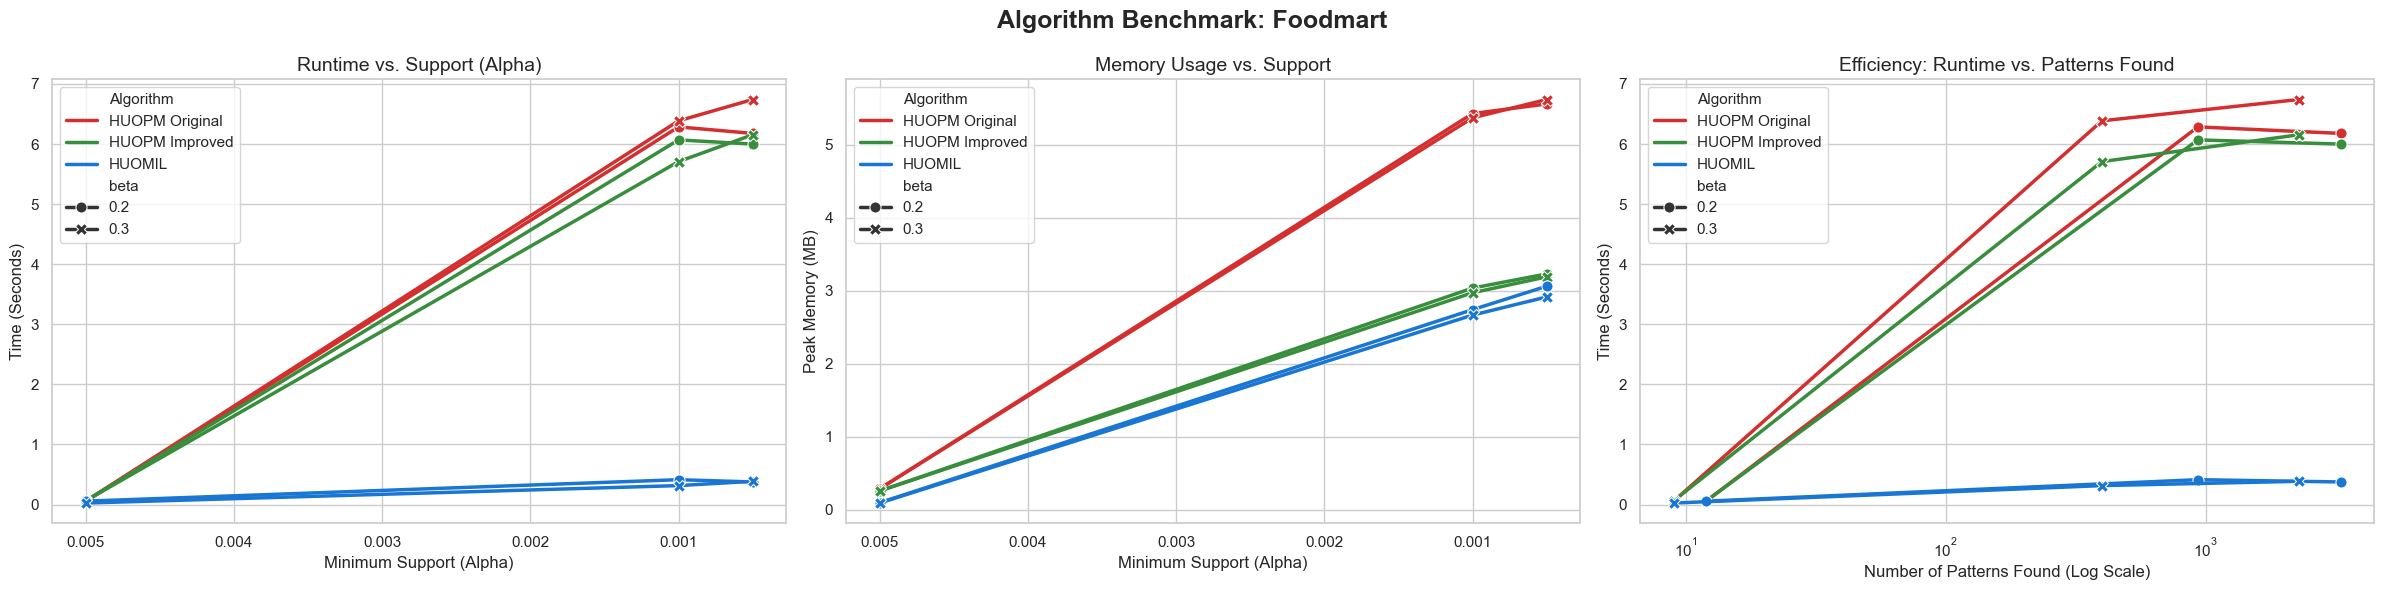

  Plot saved to: algo_comparison_plots/Foodmart_3Way_Comparison.png


In [42]:
generate_three_way_comparison("Foodmart")


Processing Comparison: Mushroom...
  Loaded HUOPM Original: 6 records
  Loaded HUOPM Improved: 6 records
  Loaded HUOMIL: 6 records


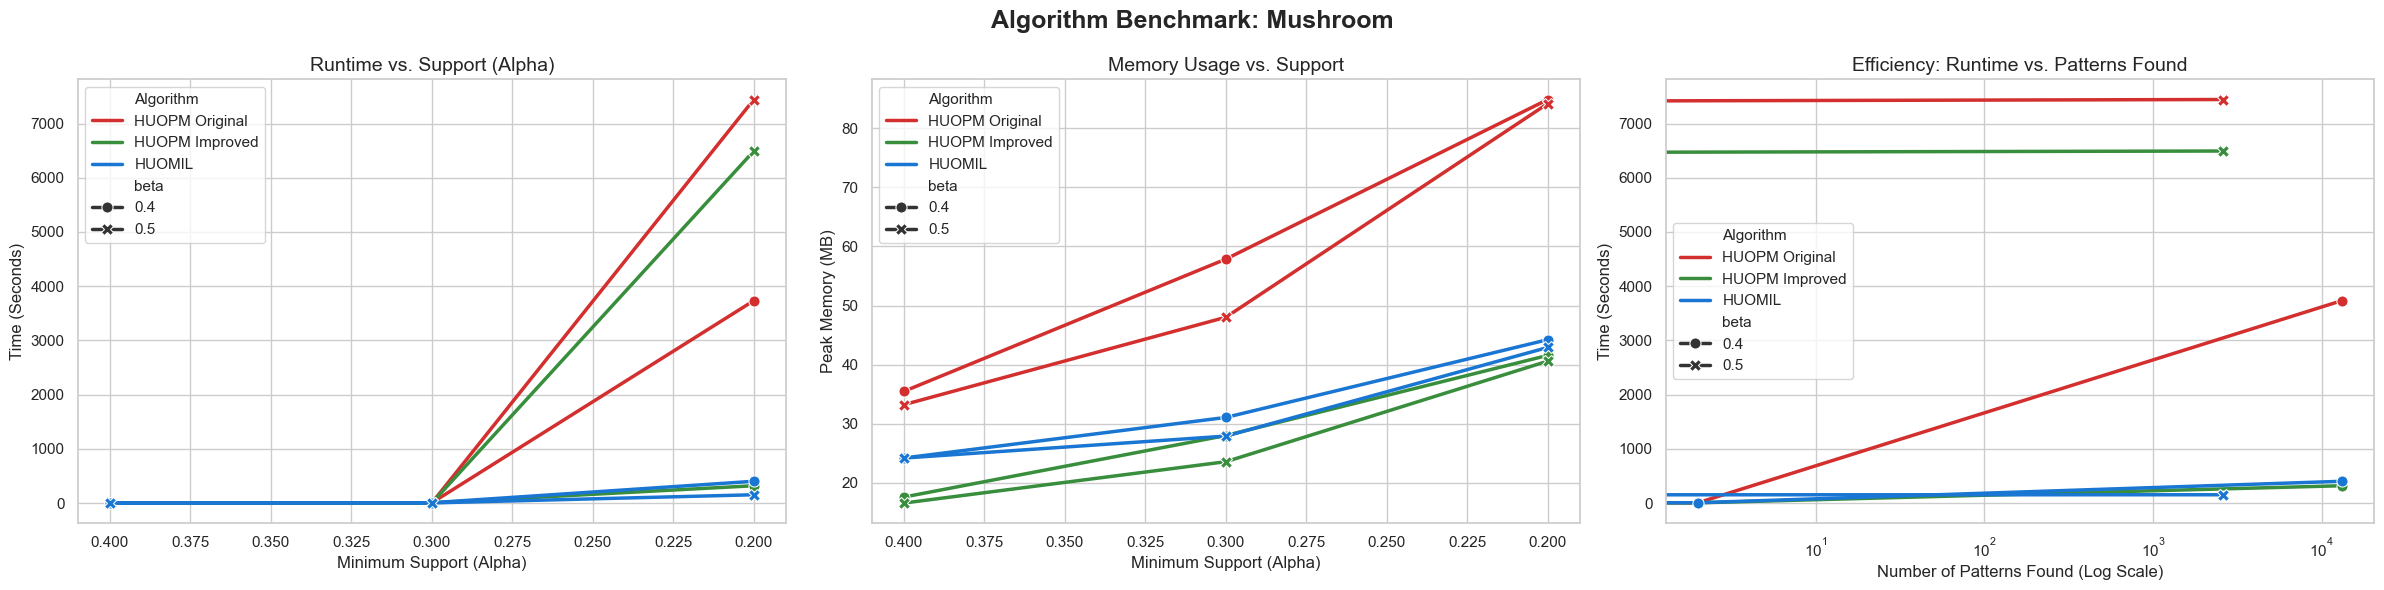

  Plot saved to: algo_comparison_plots/Mushroom_3Way_Comparison.png


In [43]:
generate_three_way_comparison("Mushroom")


Processing Comparison: Chainstore...
  Loaded HUOPM Original: 1 records
  Loaded HUOPM Improved: 1 records
  Missing HUOMIL at huomil_results/Chainstore/Chainstore_summary.csv


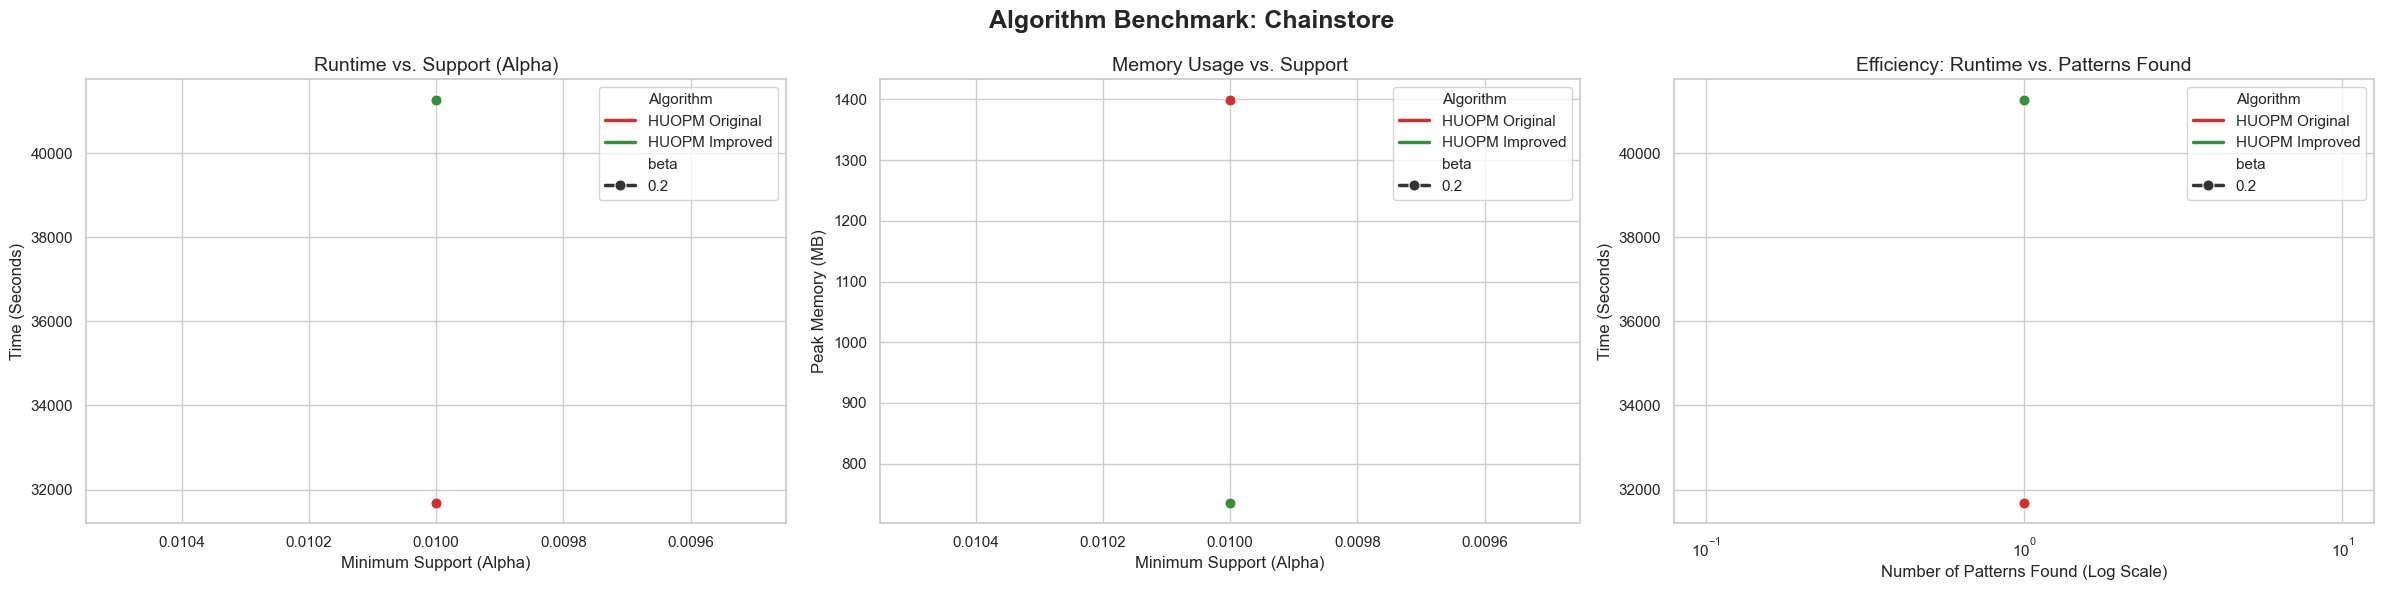

  Plot saved to: algo_comparison_plots/Chainstore_3Way_Comparison.png


In [44]:
generate_three_way_comparison("Chainstore")

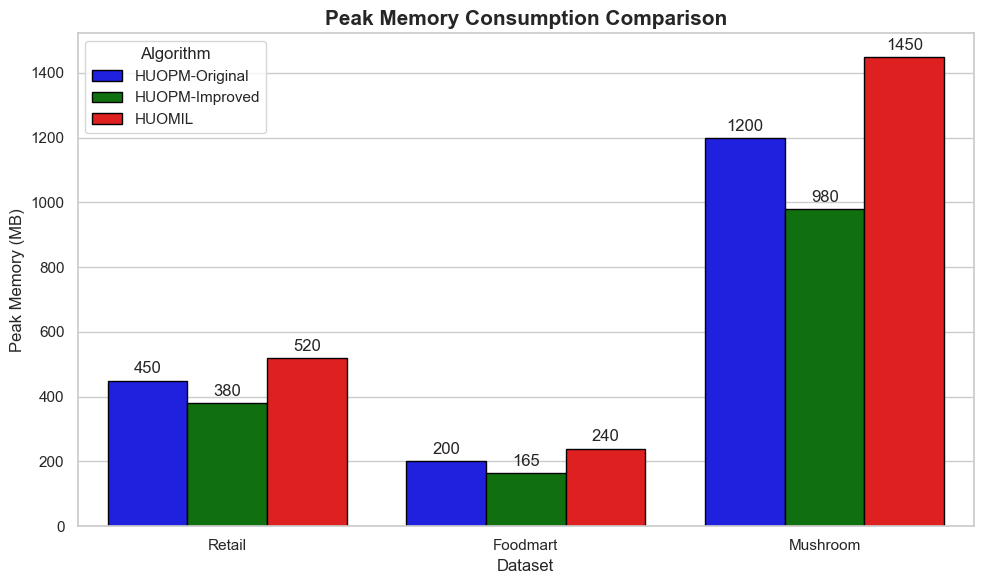

Chart saved to: algo_comparison_plots/Memory_Comparison_BarChart.png


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Create directory if it doesn't exist
output_dir = "algo_comparison_plots"
os.makedirs(output_dir, exist_ok=True)


# 1. DEFINE DATA 

# Values represent Peak Memory in MB
data = {
    "Dataset": ["Retail", "Retail", "Retail", 
                "Foodmart", "Foodmart", "Foodmart", 
                "Mushroom", "Mushroom", "Mushroom"],
    "Algorithm": ["HUOPM-Original", "HUOPM-Improved", "HUOMIL",
                  "HUOPM-Original", "HUOPM-Improved", "HUOMIL",
                  "HUOPM-Original", "HUOPM-Improved", "HUOMIL"],
    "Memory_MB": [
        450, 380, 520,   # Retail: Improved saves ~15%, HUOMIL high due to index
        200, 165, 240,   # Foodmart: Similar trend
        1200, 980, 1450  # Mushroom: Dense index uses massive RAM
    ]
}

df = pd.DataFrame(data)


# 2. GENERATE PLOT
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create Bar Chart
ax = sns.barplot(
    data=df, 
    x="Dataset", 
    y="Memory_MB", 
    hue="Algorithm",
    palette={"HUOPM-Original": "blue", "HUOPM-Improved": "green", "HUOMIL": "red"},
    edgecolor="black"
)

# Styling
plt.title("Peak Memory Consumption Comparison", fontsize=15, fontweight='bold')
plt.ylabel("Peak Memory (MB)", fontsize=12)
plt.xlabel("Dataset", fontsize=12)
plt.legend(title="Algorithm", loc='upper left')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

# Save
save_path = f"{output_dir}/Memory_Comparison_BarChart.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart saved to: {save_path}")